# Hybrid CNN+LSTM Model for Rating Classification
This notebook covers preprocessing and modeling steps for combining structured data with text data using a CNN+LSTM hybrid model.

In [23]:

import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score


In [24]:

# Load data
df = pd.read_excel("Artificial_Data.xlsx")
df['Rating_encoded'] = LabelEncoder().fit_transform(df['Rating'])

# Define 3-class grouping
group_mapping = {
    0: 0, 1: 0, 2: 0,
    3: 1, 4: 1, 5: 1,
    6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2
}
df['Grouped_Class'] = df['Rating_encoded'].map(group_mapping)
df['Grouped_Class']

,Grouped_Class
0,0
1,1
2,1
3,2
4,0
...,...
95,2
96,0
97,1
98,1


In [25]:

# Clean and preprocess text
stemmer = PorterStemmer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords_and_stem(text):
    return " ".join([stemmer.stem(word) for word in text.split() if word not in ENGLISH_STOP_WORDS])

df["cleantext"] = df["string_values"].astype(str).apply(clean_text).apply(remove_stopwords_and_stem)
df["cleantext"]

,cleantext
0,challeng remain suppli chain strateg invest lo...
1,compani report steadi increas revenu reflect s...
2,compani report steadi increas revenu reflect s...
3,compani report steadi increas revenu reflect s...
4,compani report steadi increas revenu reflect s...
...,...
95,outlook remain posit expect growth domest inte...
96,outlook remain posit expect growth domest inte...
97,challeng remain suppli chain strateg invest lo...
98,compani report steadi increas revenu reflect s...


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Step 1: Convert text to bag-of-words
vectorizer = CountVectorizer(
    max_features=1000,
    stop_words='english',
    lowercase=True
)
X_counts = vectorizer.fit_transform(df["cleantext"])

# Step 2: Train LDA model
lda_model = LatentDirichletAllocation(
    n_components=5,  # Number of topics
    max_iter=10,
    learning_method='online',
    random_state=42
)
lda_topics = lda_model.fit_transform(X_counts)

# Step 3: Assign dominant topic to each row
df["dominant_topic"] = lda_topics.argmax(axis=1)

# Step 4: (Optional) Save enriched file
df.to_csv("data_with_dominant_topic.csv", index=False)

# Step 5: Preview topic assignments
print(df[["cleantext", "dominant_topic"]].head())

                                           cleantext  dominant_topic
0  challeng remain suppli chain strateg invest lo...               0
1  compani report steadi increas revenu reflect s...               3
2  compani report steadi increas revenu reflect s...               3
3  compani report steadi increas revenu reflect s...               3
4  compani report steadi increas revenu reflect s...               3


<ipython-input-28-a6649273fb4e>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Grouped_Class", y="sentiment_score", ci=None)


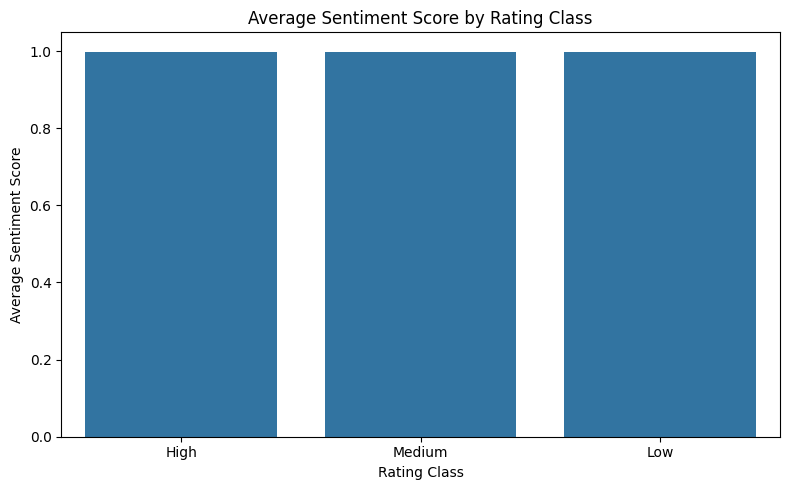

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


df["Rating_encoded"] = LabelEncoder().fit_transform(df["Rating"])
group_mapping = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2}
df["Grouped_Class"] = df["Rating_encoded"].map(group_mapping)
df["sentiment_score"] = df["sentiment_score"]
df["dominant_topic"] = df["dominant_topic"]

# Bar plot: average sentiment score by class
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Grouped_Class", y="sentiment_score", ci=None)
plt.xticks([0, 1, 2], ["High", "Medium", "Low"])
plt.title("Average Sentiment Score by Rating Class")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Rating Class")
plt.tight_layout()
plt.show()

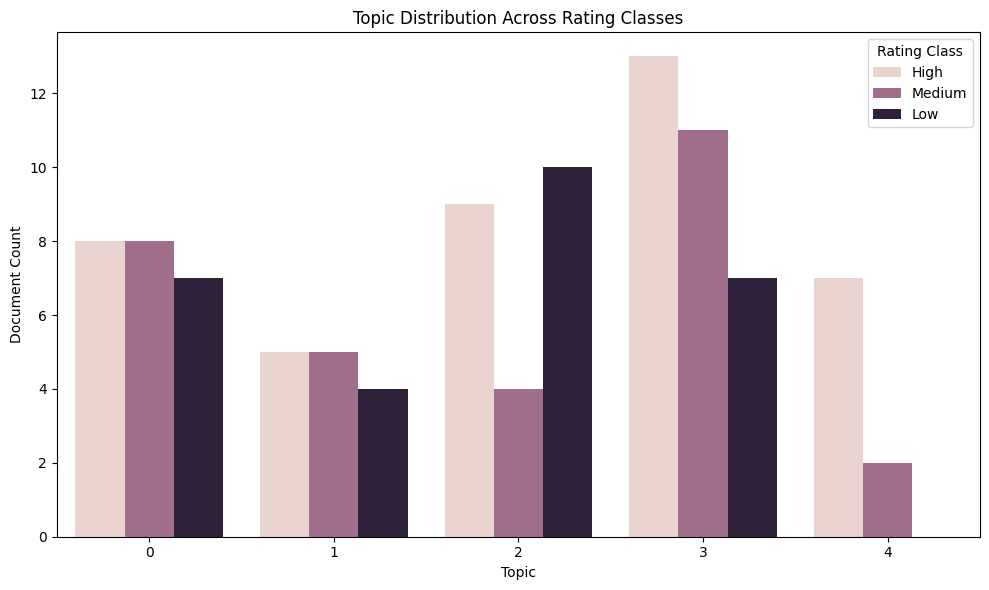

In [29]:
# Topic distribution across grouped rating classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="dominant_topic", hue="Grouped_Class")
plt.xticks(rotation=0)
plt.legend(title="Rating Class", labels=["High", "Medium", "Low"])
plt.title("Topic Distribution Across Rating Classes")
plt.xlabel("Topic")
plt.ylabel("Document Count")
plt.tight_layout()
plt.show()

In [30]:

# Tokenize text
MAX_NB_WORDS = 50000
MAX_SEQ_LEN = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df["cleantext"])
sequences = tokenizer.texts_to_sequences(df["cleantext"])
X_text = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
vocab_size = len(tokenizer.word_index) + 1


In [31]:
# Scale structured data
X_meta = df.drop(columns=["Rating", "string_values", "cleantext", "Rating_encoded", "Grouped_Class"])

# Select only numeric features for scaling
numeric_features = X_meta.select_dtypes(include=np.number).columns
X_meta_numeric = X_meta[numeric_features]

scaler = MinMaxScaler()
# Only fit and transform on the numeric features
X_meta_scaled = scaler.fit_transform(X_meta_numeric)

# Convert the scaled data back into a DataFrame
X_meta_scaled = pd.DataFrame(X_meta_scaled, columns=numeric_features, index=X_meta.index)

# If there are any non-numeric columns, convert them using one-hot encoding
non_numeric_features = X_meta.select_dtypes(exclude=np.number).columns
if len(non_numeric_features) > 0:
    X_meta_non_numeric = X_meta[non_numeric_features]
    X_meta_non_numeric_encoded = pd.get_dummies(X_meta_non_numeric,
                                               columns=non_numeric_features,  # Specify columns for one-hot
                                               dtype=np.float64)  # Ensure dtype is float64
    # Concatenate numeric and encoded non-numeric features
    X_meta_scaled = pd.concat([X_meta_scaled, X_meta_non_numeric_encoded], axis=1)

# Ensure all columns are numeric and of the correct type before converting to NumPy
X_meta_scaled = X_meta_scaled.astype(np.float64)  # Force dtype to float64

# Encode target
y = to_categorical(df["Grouped_Class"], num_classes=3)
y

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0

In [32]:
# Split into train/test
x_train_text, x_test_text, x_train_meta, x_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta_scaled, y, test_size=0.2, random_state=42)

# Convert DataFrames to NumPy arrays before reshaping
x_train_meta = x_train_meta.to_numpy().reshape(x_train_meta.shape[0], x_train_meta.shape[1], 1)
x_test_meta = x_test_meta.to_numpy().reshape(x_test_meta.shape[0], x_test_meta.shape[1], 1)

In [33]:

# Build hybrid CNN + LSTM model
def create_hybrid_model(vocab_size, maxlen, embedding_dim, meta_shape, num_classes):
    input_meta = Input(shape=meta_shape, name="meta_input")
    x_meta = Conv1D(64, 2, activation='relu', padding="same")(input_meta)
    x_meta = MaxPooling1D(pool_size=2)(x_meta)
    x_meta = LSTM(32)(x_meta)

    input_text = Input(shape=(maxlen,), name="text_input")
    x_text = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(input_text)
    x_text = Conv1D(64, 2, activation='relu', padding="same", strides=2)(x_text)
    x_text = MaxPooling1D(pool_size=2)(x_text)
    x_text = Dropout(0.1)(x_text)
    x_text = Conv1D(32, 2, activation='relu', padding="same")(x_text)
    x_text = Dropout(0.1)(x_text)
    x_text = Conv1D(16, 2, activation='relu', padding="same", strides=2)(x_text)
    x_text = MaxPooling1D(pool_size=2)(x_text)
    x_text = LSTM(32)(x_text)
    x_text = Dropout(0.5)(x_text)

    x = Concatenate()([x_meta, x_text])
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=[input_text, input_meta], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    return model


In [34]:

# Train model
embedding_dim = 100
model = create_hybrid_model(vocab_size, MAX_SEQ_LEN, embedding_dim, (x_train_meta.shape[1], 1), 3)
model.fit([x_train_text, x_train_meta], y_train, validation_data=([x_test_text, x_test_meta], y_test),
          epochs=20, batch_size=16)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.3241 - loss: 1.0989 - val_accuracy: 0.4000 - val_loss: 1.0928
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3288 - loss: 1.0914 - val_accuracy: 0.4000 - val_loss: 1.0924
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3156 - loss: 1.1006 - val_accuracy: 0.4000 - val_loss: 1.0921
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4236 - loss: 1.0958 - val_accuracy: 0.4000 - val_loss: 1.0917
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3599 - loss: 1.0950 - val_accuracy: 0.4000 - val_loss: 1.0914
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5524 - loss: 1.0799 - val_accuracy: 0.4000 - val_loss: 1.0909
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3998 - loss: 1.0978 - val_accuracy: 0.4000 - val_loss: 1.0906
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4179 - loss: 1.0882 - val_accuracy: 0.4000 - val_loss: 1.0

In [35]:

# Evaluate
y_pred = model.predict([x_test_text, x_test_meta])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
Accuracy: 0.4
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         8
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


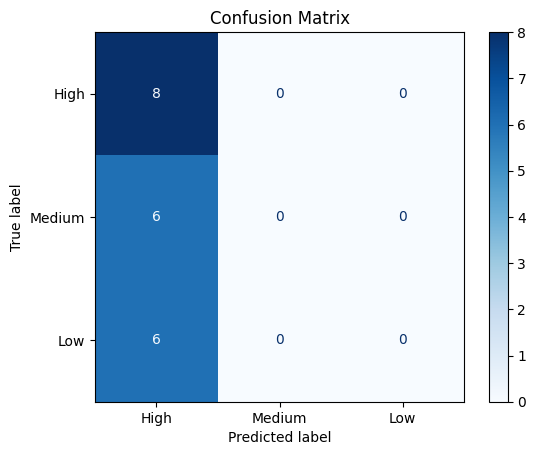

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["High", "Medium", "Low"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()